# **Đồ án môn học**
## Môn: Lập trình song song ứng dụng
### Lớp CQ2021/21 - Nhóm 05
#### Thành viên:
| Họ và tên             | MSSV |
| :-----------          |     :----:|
| Diệp Đại Thiện Nhân | 18120491  |
| Hoàng Trung Nam  | 21120290 |


# **Tổng quan đồ án**

- Nhóm quyết định thử sức với VGG.

- VGG là một kiến trúc CNN sâu được giới thiệu bởi nhóm VGG (Visual Geometry Group) thuộc Đại học Oxford năm 2014. Kiến trúc này nổi bật bởi việc sử dụng nhiều lớp convolution 3x3 liên tiếp thay vì một lớp convolution lớn (vd: 5x5 hay 7x7), nhằm tăng khả năng học đặc trưng và giữ kích thước receptive field ổn định.

- Hai phiên bản phổ biến:
  - VGG-16: 16 lớp có trọng số (13 conv + 3 FC).
  - VGG-19: 19 lớp có trọng số (16 conv + 3 FC).

- **Input của CIFAR-10** là `32x32x3`, nhỏ hơn rất nhiều so với `224x224x3` của VGG gốc.

Vậy nên, khi áp dụng VGG cho CIFAR-10, ta cần **giảm số lượng layer** hoặc **điều chỉnh input size** như sau:

## **Kiến trúc mô hình cụ thể**

- **Input Layer**  
  - 32×32×3 (RGB)

- **Block 1**  
  - Conv3×3, 64 filters + ReLU  
  - Conv3×3, 64 filters + ReLU  
  - MaxPool 2×2

- **Block 2**  
  - Conv3×3, 128 filters + ReLU  
  - Conv3×3, 128 filters + ReLU  
  - MaxPool 2×2

- **Block 3**  
  - Conv3×3, 256 filters + ReLU  
  - Conv3×3, 256 filters + ReLU  
  - MaxPool 2×2

- **Fully Connected**  
  - FC 512 + ReLU  
  - FC 10 + Softmax

- **Optimization**  
  - Loss: Cross‑Entropy  
  - Optimizer: SGD/Adam  
  - Parallelization: Viết bằng Numpy → tối ưu với Numba (`@cuda.jit`)

Kiến trúc VGG‑like này giữ tinh thần “nhiều conv 3×3” của VGG gốc nhưng thu gọn cho phù hợp với kích thước ảnh 32×32 và dataset CIFAR‑10.

## **Dataset**

- **CIFAR-10**:
  - 60.000 ảnh màu 32×32 thuộc 10 lớp.

  - 50.000 ảnh train, 10.000 ảnh test.

  - Link: https://www.cs.toronto.edu/~kriz/cifar.html

## **Nội dung đã hoàn thành**

## **Cài đặt hàm tuần tự**

### **Ý tưởng**

#### 📥 Input Layer

- Kích thước ảnh: **32 × 32 × 3 (RGB)**  
- Sau mỗi layer, kích thước thay đổi tùy theo padding và pooling.

---

#### 🧠 1. Convolutional Layer (3×3)

**Công thức:**

$$
Y[i,j,cout] = \sum_{u=0}^{2} \sum_{v=0}^{2} \sum_{cin=0}^{C_{in}-1} K[u,v,cin,cout] \cdot X[i+u, j+v, cin]
$$

**Chú thích biến:**
- $ X $ : ảnh đầu vào, kích thước (H, W, Cin)
- $K$: kernel/lọc, kích thước (3, 3, Cin, Cout)
- $Y$: ảnh đầu ra sau convolution, kích thước (H', W', Cout)
- $i, j$: vị trí không gian
- $u, v$: tọa độ trong kernel
- $cin, cout$: chỉ số kênh đầu vào và đầu ra

**Song song hóa:**  
✔ Mỗi phần tử $Y[i,j,cout]$ độc lập → triển khai bằng `@cuda.jit` (Numba)

---

#### ⚡ 2. Activation Layer (ReLU)

**Công thức:**

$$
A[i,j,c] = \max(0, Z[i,j,c])
$$

**Chú thích biến:**
- $Z$ : đầu ra từ convolution
- $A$: đầu ra sau kích hoạt ReLU

**Song song hóa:**  
✔ Mỗi phần tử độc lập → dùng `@vectorize` hoặc `@cuda.jit`

---

#### 🌊 3. Max Pooling Layer (2×2)

**Công thức:**

$$
P[i,j,c] = \max \begin{Bmatrix}
X[2i, 2j, c], & X[2i+1, 2j, c], \\
X[2i, 2j+1, c], & X[2i+1, 2j+1, c]
\end{Bmatrix}
$$

**Chú thích biến:**
- $X$: đầu vào trước pooling
- $P$: đầu ra sau pooling
- $i, j$: vị trí trên ảnh pooling
- $c$ : kênh màu

**Song song hóa:**  
✔ Mỗi vùng pooling độc lập → dùng `@cuda.jit`

---

#### 🧩 4. Fully Connected Layer (FC)

**Công thức:**

$$
y_k = \sum_{d=0}^{D-1} W[d,k] \cdot x_d + b_k
$$

**Chú thích biến:**
- $x$: vector đầu vào đã flatten (sau các conv)
- $W$: ma trận trọng số FC (D, K)
- $b$: bias
- $y$: output vector

**Song song hóa:**  
✔ Mỗi $y_k$ độc lập → dùng `@cuda.jit` hoặc `@njit(parallel=True)`

---

#### 🔥 5. Softmax + Cross-Entropy Loss

**Softmax:**

$$
p_i = \frac{e^{y_i}}{\sum_j e^{y_j}}
$$

**Loss:**

$$
L = -\sum_i t_i \cdot \log(p_i)
$$

**Chú thích biến:**
- $y_i$: giá trị đầu ra từ FC
- $p_i$: xác suất sau softmax
- $t_i$: nhãn thật (one-hot)
- $L$: hàm mất mát

**Song song hóa:**  
✘ Không cần, tính nhẹ, có thể xử lý trên CPU

---

#### 🔁 6. Backpropagation + Weight Update

##### Gradient của Softmax + CrossEntropy:

$$
\frac{\partial L}{\partial y_i} = p_i - t_i
$$

---

##### Gradient của FC:

$$
\frac{\partial L}{\partial W[d,k]} = x_d \cdot \frac{\partial L}{\partial y_k}
\quad ; \quad
\frac{\partial L}{\partial b_k} = \frac{\partial L}{\partial y_k}
$$

**Song song hóa:** ✔ từng phần tử độc lập → `@cuda.jit`

---

##### Gradient của ReLU:

$$
\frac{\partial L}{\partial Z[i,j,c]} = 
\begin{cases}
\frac{\partial L}{\partial A[i,j,c]}, & \text{if } Z[i,j,c] > 0 \\
0, & \text{otherwise}
\end{cases}
$$

---

##### Gradient của Convolution:

$$
\frac{\partial L}{\partial K[u,v,cin,cout]} = \sum_{i,j} \frac{\partial L}{\partial Y[i,j,cout]} \cdot X[i+u,j+v,cin]
$$

$$
\frac{\partial L}{\partial X[i,j,cin]} = \sum_{u,v,cout} \frac{\partial L}{\partial Y[i-u,j-v,cout]} \cdot K[u,v,cin,cout]
$$

**Song song hóa:** ✔ nặng nhất → dùng `@cuda.jit` để tối ưu

---

#### ✅ Tóm tắt khả năng song song hóa

| Lớp              | Cần song song | Ghi chú                                |
|------------------|----------------|----------------------------------------|
| Convolution       | ✅              | Tính toán nặng, phần tử độc lập         |
| ReLU              | ✅              | Mỗi phần tử tính riêng được             |
| Max Pooling       | ✅              | Mỗi vùng pooling độc lập               |
| Fully Connected   | ✅              | Mỗi neuron đầu ra độc lập              |
| Softmax + Loss    | ❌              | Tính nhẹ, xử lý CPU vẫn hiệu quả       |
| Backpropagation   | ✅              | Các đạo hàm có thể tính độc lập        |



### **Chuẩn bị dữ liệu**

In [6]:
import os
import urllib.request
import tarfile

def download_cifar10():
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    filename = 'cifar-10-python.tar.gz'
    folder = 'cifar-10-batches-py'

    if not os.path.exists(filename):
        print("⏬ Downloading CIFAR-10...")
        urllib.request.urlretrieve(url, filename)

    if not os.path.exists(folder):
        print("📦 Extracting CIFAR-10...")
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
    print("✅ Done.")

download_cifar10()

⏬ Downloading CIFAR-10...
📦 Extracting CIFAR-10...


C:\Users\WIN 10\AppData\Local\Temp\ipykernel_9612\3000658681.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


✅ Done.


In [10]:
import pickle
import numpy as np

def load_batch(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        images = data[b'data']
        labels = data[b'labels']
        images = images.reshape(-1, 3, 32, 32)  # N x C x H x W
        return images, labels

def load_cifar10_data():
    base_dir = 'cifar-10-batches-py'
    X_train, y_train = [], []

    # Load 5 training batches
    for i in range(1, 6):
        images, labels = load_batch(f'{base_dir}/data_batch_{i}')
        X_train.append(images)
        y_train += labels

    # Load test batch
    X_test, y_test = load_batch(f'{base_dir}/test_batch')

    # Convert to numpy arrays
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_cifar10_data()
print("✅ CIFAR-10 loaded:", X_train.shape, y_train.shape)


✅ CIFAR-10 loaded: (50000, 3, 32, 32) (50000,)


In [11]:
# Đưa giá trị pixel về [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
print("✅ Normalized CIFAR-10 data:", X_train.shape, y_train.shape)
print("✅ Normalized CIFAR-10 test data:", X_test.shape, y_test.shape)

✅ Normalized CIFAR-10 data: (50000, 3, 32, 32) (50000,)
✅ Normalized CIFAR-10 test data: (10000, 3, 32, 32) (10000,)


In [12]:
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)
print("✅ One-hot encoded CIFAR-10 labels:", y_train_oh.shape)
print("✅ One-hot encoded CIFAR-10 test labels:", y_test_oh.shape)

✅ One-hot encoded CIFAR-10 labels: (50000, 10)
✅ One-hot encoded CIFAR-10 test labels: (10000, 10)


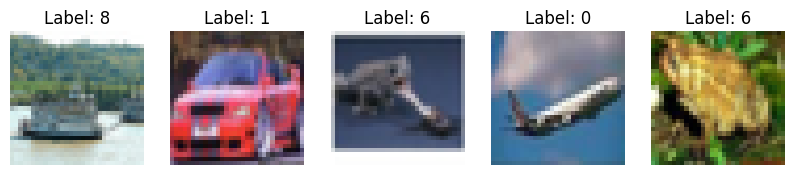

In [ ]:
# in các ảnh ngẫu nhiên
import matplotlib.pyplot as plt
import random

def show_random_images(X, y, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        idx = random.randint(0, len(X) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx].transpose(1, 2, 0))  # Chuyển đổi từ (C, H, W) sang (H, W, C)
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.show()

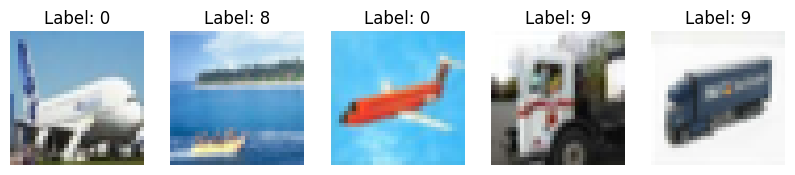

In [20]:
show_random_images(X_train, y_train)

In [23]:
# in cây thư mục hiện tại
import os
import json
import datetime
import shutil
import zipfile
import re

def print_directory_tree(path='.'):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

print("📂 Current directory tree:")
print_directory_tree()

📂 Current directory tree:
./
    app_group7.ipynb
    cifar-10-python.tar.gz
    Image_Classification.ipynb
    README.md
    .git/
        COMMIT_EDITMSG
        config
        description
        FETCH_HEAD
        HEAD
        index
        ORIG_HEAD
        packed-refs
        hooks/
            applypatch-msg.sample
            commit-msg.sample
            fsmonitor-watchman.sample
            post-update.sample
            pre-applypatch.sample
            pre-commit.sample
            pre-merge-commit.sample
            pre-push.sample
            pre-rebase.sample
            pre-receive.sample
            prepare-commit-msg.sample
            push-to-checkout.sample
            sendemail-validate.sample
            update.sample
        info/
            exclude
        logs/
            HEAD
            refs/
                heads/
                    main
                    nam
                remotes/
                    origin/
                        HEAD
              